In [57]:
# This is to modify the geogrid file created from geogrid.exe of WPS

from netCDF4 import Dataset
from glob import glob
import os, sys

is_py = os.path.basename(sys.argv[0]) == 'geogrid.ju.py'
root_dir = '/home/guc/'
all_files = glob(root_dir + '/Build_WRF/WPS/' + 'geo_em*')
# all_files = glob(root_dir + 'runs/025*/' + 'geo_em*')

In [58]:
# Only take one domain for now
dataset = Dataset(all_files[0])

def list_variables(dataset: Dataset) -> None:
    '''
    List all variables in the nc dataset for adjustment
    dataset:    netcdf dataset
    '''
    print('\n'.join(map(lambda x: f"{x.name}: {dataset[x.name].__dict__.get('description')} {x.dimensions}", dataset.variables.values())))

def list_landuse(dataset: Dataset) -> None:
    attrs = dataset.__dict__
    print(f"Land use category (MMINLU), check with WRF/LANDUSE.TBL: {attrs['MMINLU']}")
    print(f"Land use category number (NUM_LAND_CAT): {attrs['NUM_LAND_CAT']}")
    print(f"Water type index (ISWATER): {attrs['ISWATER']}")
    print(f"Urban type index (ISWATER): {attrs['ISURBAN']}")

def list_urban_vars_min_max(dataset: Dataset) -> None:
    urban_vars = ['MH_URB2D', 'ZD_URB2D', 'Z0_URB2D', 'BUILD_AREA_FRACTION', 'LF_URB2D_S', 'AHE']
    for var_name in urban_vars:
        print(f'{var_name}: mean = {dataset.variables[var_name][:].mean()} max = {dataset.variables[var_name][:].max()}')

# list_variables(dataset)
# list_urban_vars_min_max(dataset)
# list_landuse(dataset)

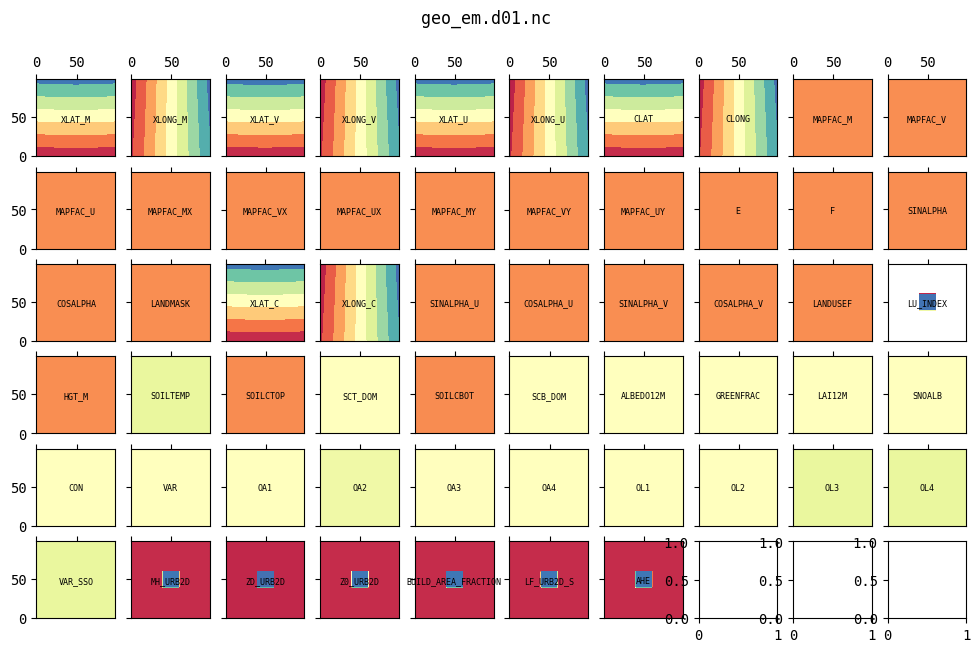

In [59]:
import matplotlib.pyplot as plt
import math

def plot_all_vars(dataset: Dataset) -> None:
    cols_num, len_vars = 10, len(dataset.variables)
    fig, axes = plt.subplots(math.ceil(len_vars / cols_num), cols_num, figsize=(12, 7))
    idx: int = 0
    for var in dataset.variables.values():
        i, j = idx // cols_num, idx % cols_num
        axes[i][j].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        axes[i][j].set_title(var.name, x=0.5, y=0.35, fontweight="500", fontsize=6)
        if j != 0: axes[i][j].set_yticklabels([])
        if i != 0: axes[i][j].set_xticklabels([])
        if len(var.shape) == 3: axes[i][j].contourf(var[0], cmap='Spectral')
        elif len(var.shape) == 4: axes[i][j].contourf(var[0][0], cmap='Spectral')
        else: continue
        idx += 1
    fig.suptitle('geo_em.d01.nc')

if not is_py:
    plot_all_vars(dataset)

In [60]:
import numpy as np

def modify_convert_uniform(src: Dataset, var_names: list[str]) -> Dataset:
    '''
    Convert all variables in the src file to uniform average
    src         source dataset
    var_names   list of variable names to average
    '''

    for var_name in var_names:
        modified_var = src.variables[var_name][:]
        print(f'Averaging {var_name}...', end='\r')
        for time_idx in range(src.variables[var_name].shape[0]):
            average_value = np.mean(src.variables[var_name][time_idx])
            modified_var[time_idx][:] = average_value
        src.variables[var_name][:] = modified_var

    return src

In [61]:
def modify_map_factor(src: Dataset) -> Dataset:
    '''
    Adjust map factor to 1
    src         source dataset
    '''
    for var_name in src.variables.keys():
        if var_name.split('_')[0] == 'MAPFAC':
            src.variables[var_name][:] = 1

    return src

In [62]:
WATER_CUTOFF_IDX = 50
URBAN_SIZE = (80, 80)
urban_mask = (
    slice(50 - URBAN_SIZE[0] // 2, 50 + URBAN_SIZE[0] // 2,), 
    slice(50 - URBAN_SIZE[0] // 2, 50 + URBAN_SIZE[0] // 2,), 
    None
)

def modify_landuse(src: Dataset) -> Dataset:
    '''
    Modify the land use category
    src     source dataset
    '''
    attrs = src.__dict__
    land_use_cat = {
        'urban': attrs['ISURBAN'],         # Urban and Built-up Land
        'water': attrs['ISWATER'],        # Water Bodies
        'grassland': 10,     # Grassland
    }

    # Modify the land use index. To check the variables,
    # see LANDUSE.TBL and num_land_cat in namelist.input
    # 24 - for USGS (default); 20 for MODIS
    # 28 - for USGS if including lake category
    # 21 - for MODIS if including lake category (default since 3.8)
    # 40 - for NCLD
    # Currently using USGS (num_land_cat = 24)
    modified_lu = src.variables['LU_INDEX'][:]
    modified_lu[0][:] = land_use_cat['grassland']
    modified_lu[0][urban_mask] = land_use_cat['urban']
    src.variables['LU_INDEX'][:] = modified_lu

    # Modify land mask, 1 for land, 0 for water
    modified_landmask = src.variables['LANDMASK'][:]
    modified_landmask[0][:] = 1 # Land
    src.variables['LANDMASK'][:] = modified_landmask

    # Modify land use fraction
    # https://forum.mmm.ucar.edu/threads/difference-between-landusef-and-frc_urb2d.10455/
    # Basically you need to modify the fraction of land to the corresponding
    # array index
    modified_landusef = src.variables['LANDUSEF'][:]
    modified_landusef[:] = 0 # Reset everything, probably easier
    modified_landusef[0][land_use_cat['grassland']][:] = 1.0

    # No grassland here
    modified_landusef[0][land_use_cat['grassland']][urban_mask] = 0
    modified_landusef[0][land_use_cat['urban']][urban_mask] = 1.0
    src.variables['LANDUSEF'][:] = modified_landusef

    return src

In [63]:
def modify_height(src: Dataset) -> Dataset:
    '''
    Modify terrain height of input file
    src     source dataset
    '''
    src.variables['HGT_M'][:] = 0

    return src

In [64]:
def modify_urban_area(src: Dataset) -> Dataset:
    '''
    Modify urban related variables
    src     source dataset
    '''
    urban_vars = [
        ('MH_URB2D',            50   ),
        ('ZD_URB2D',            20   ),
        ('Z0_URB2D',            1 ),
        ('BUILD_AREA_FRACTION', 1 ),
        ('LF_URB2D_S',          0.5 ),
    ]
    for var_name, value in urban_vars:
        modified_var = np.zeros(src.variables[var_name].shape)
        for time_idx in range(src.variables[var_name].shape[0]):
            modified_var[time_idx][urban_mask] = value
        src.variables[var_name][:] = modified_var

    # Modify AHE
    ahe_value = 200
    modified_ahe = np.zeros(src.variables['AHE'].shape)
    for time_idx in range(modified_ahe.shape[0]):
        for month_hour_idx in range(modified_ahe.shape[1]):
            modified_ahe[time_idx][month_hour_idx][urban_mask] = ahe_value
    src.variables['AHE'][:] = modified_ahe

    return src

In [65]:
def modify_urban_zero(src: Dataset) -> Dataset:
    src.variables['MH_URB2D'][:] = 0
    src.variables['Z0_URB2D'][:] = 0
    src.variables['ZD_URB2D'][:] = 0
    src.variables['BUILD_AREA_FRACTION'][:] = 0
    src.variables['LF_URB2D_S'][:] = 0
    src.variables['AHE'][:] = 0

    return src

In [66]:
def modify_cos_sin_a(src: Dataset) -> Dataset:
    src.variables['COSALPHA'][:] = 1
    src.variables['SINALPHA'][:] = 0

    src.variables['COSALPHA_U'][:] = 1
    src.variables['SINALPHA_U'][:] = 0
    src.variables['COSALPHA_V'][:] = 1
    src.variables['SINALPHA_V'][:] = 0

    src.variables['E'][:] = 0
    src.variables['F'][:] = 0
    return src

In [67]:
import time

# file_name: str = 'test_geo_em.d01.nc' + f'{time.time()}'
file_name: str = 'geo_em.d01.nc'
output_name: str = root_dir + 'modified-files/' + file_name

if len(glob(output_name)) > 0:
    os.remove(output_name)

with Dataset(all_files[0], 'r', format='NETCDF4') as src:
    with Dataset(output_name, 'w', format='NETCDF4') as out:
        # Get the attributes of the original file
        attributes = src.__dict__

        # Add extra field to attrs, e.g. notes
        attributes['TITLE'] += ' (MODIFIED)'
        attributes['NOTE'] = 'Idealized Urban-grassland by Mok'

        # Set it into the output
        out.setncatts(attributes)

        # Copy dimensions
        for name, dimension in src.dimensions.items():
            dimension_size = (
                len(dimension) if not dimension.isunlimited() else None
            ) # The value should be None for unlimited dimension

            # Create the dimension with its size, make sure to modify it
            # if you changed the variable dimension
            out.createDimension(name, dimension_size)

        # Modify the variable, see function on the cell above
        for name, variable in src.variables.items():
            out.createVariable(
                name,
                variable.datatype,
                variable.dimensions,
                zlib = True,            # Lossless compression (optional)
                complevel = 5,          # Lossless compression (optional)
                shuffle = True          # Lossless compression (optional)
            )

            # Set output variable attributes
            out[name].setncatts(src[name].__dict__)
            out[name][:] = src[name][:]

        var_names = [
            'SOILTEMP', 'SOILCTOP', 'SCT_DOM', 'SOILCBOT',
            'SCB_DOM', 'ALBEDO12M', 'GREENFRAC', 'LAI12M',
            'SNOALB', 'CON', 'VAR', 'OA1', 'OA2', 'OA3', 'OA4',
            'OL1', 'OL2', 'OL3', 'OL4', 'VAR_SSO',
            # 'XLAT_M', 'XLONG_M',
        ]

        out = modify_convert_uniform(out, var_names)

        out = modify_landuse(out)
        out = modify_height(out)
        out = modify_map_factor(out)
        # out = modify_urban_zero(out)
        out = modify_urban_area(out)
        out = modify_cos_sin_a(out)
    print('Done! Congrats 🎉')

Done! Congrats 🎉.....


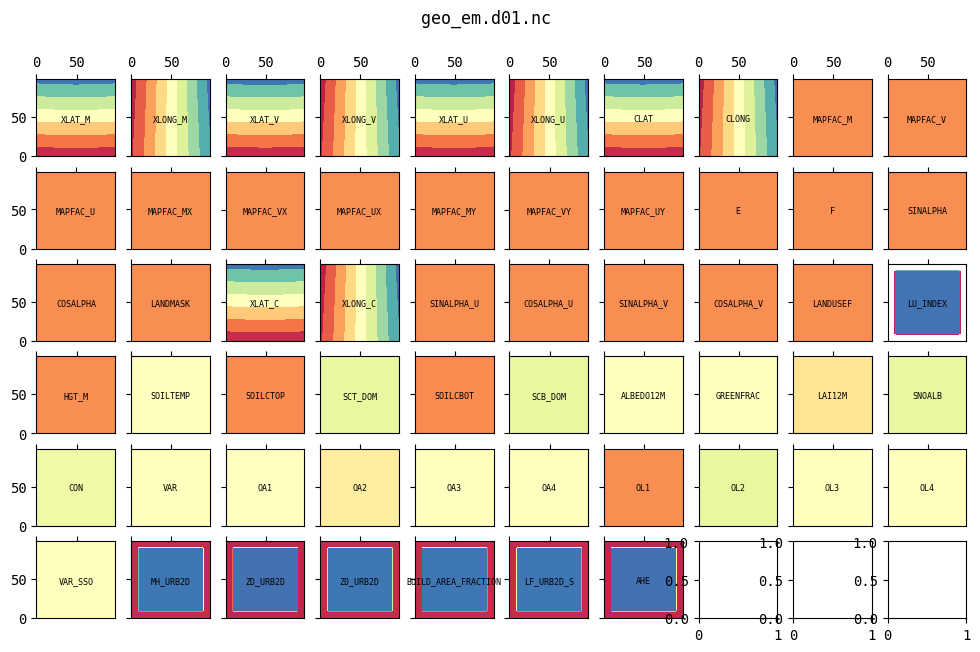

In [68]:
import matplotlib.pyplot as plt
import subprocess

# Replace the destination file
if is_py:
    subprocess.call(['mv', output_name, all_files[0]])
else:
    # Test reading output file
    out_dataset = Dataset(output_name)
    plot_all_vars(out_dataset)